# Assignment 3: Hello Vectors

Welcome to this week's programming assignment of the specialization. In this assignment we will explore word vectors.
In natural language processing, we represent each word as a vector consisting of numbers.
The vector encodes the meaning of the word. These numbers (or weights) for each word are learned using various machine
learning models, which we will explore in more detail later in this specialization. Rather than make you code the
machine learning models from scratch, we will show you how to use them. In the real world, you can always load the
trained word vectors, and you will almost never have to train them from scratch. In this assignment you will

- Predict analogies between words.
- Use PCA to reduce the dimensionality of the word embeddings and plot them in two dimensions.
- Compare word embeddings by using a similarity measure (the cosine similarity).
- Understand how these vector space models work.



## 1.0 Predict the Countries from Capitals

During the presentation of the module, we have illustrated the word analogies
by finding the capital of a country from the country. In this part of the assignment
we have changed the problem a bit. You are asked to predict the **countries** 
that corresponde to some **capitals**.
You are playing trivia against some second grader who just took their geography test and knows all the capitals by heart.
Thanks to NLP, you will be able to answer the questions properly. In other words, you will write a program that can give
you the country by its capital. That way you are pretty sure you will win the trivia game. We will start by exploring the data set.

<img src = './images/map.jpg' width="width" height="height" style="width:467px;height:300px;"/>

## Important Note on Submission to the AutoGrader

Before submitting your assignment to the AutoGrader, please make sure you are not doing the following:

1. You have not added any _extra_ `print` statement(s) in the assignment.
2. You have not added any _extra_ code cell(s) in the assignment.
3. You have not changed any of the function parameters.
4. You are not using any global variables inside your graded exercises. Unless specifically instructed to do so, please refrain from it and use the local variables instead.
5. You are not changing the assignment code where it is not required, like creating _extra_ variables.

If you do any of the following, you will get something like, `Grader not found` (or similarly unexpected) error upon submitting your assignment. Before asking for help/debugging the errors in your assignment, check for these first. If this is the case, and you don't remember the changes you have made, you can get a fresh copy of the assignment by following these [instructions](https://www.coursera.org/learn/classification-vector-spaces-in-nlp/supplement/YLuAg/h-ow-to-refresh-your-workspace).

###  1.1 Importing the data

As usual, you start by importing some essential Python libraries and the load dataset.
The dataset will be loaded as a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/getting_started/dsintro.html),
which is very a common method in data science. Because of the large size of the data,
this may take a few minutes.

In [3]:
# Run this cell to import packages.
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import w3_unittest

from utils import get_vectors

In [4]:
data = pd.read_csv('./data/capitals.txt', delimiter=' ')
data.columns = ['city1', 'country1', 'city2', 'country2']

# print first five elements in the DataFrame
data.head(5)

,city1,country1,city2,country2
0,Athens,Greece,Bangkok,Thailand
1,Athens,Greece,Beijing,China
2,Athens,Greece,Berlin,Germany
3,Athens,Greece,Bern,Switzerland
4,Athens,Greece,Cairo,Egypt


***

### To Run This Code On Your Own Machine:
Note that because the original google news word embedding dataset is about 3.64 gigabytes,
the workspace is not able to handle the full file set.  So we've downloaded the full dataset,
extracted a sample of the words that we're going to analyze in this assignment, and saved
it in a pickle file called word_embeddings_capitals.p

If you want to download the full dataset on your own and choose your own set of word embeddings,
please see the instructions and some helper code.

- Download the dataset from this [page](https://code.google.com/archive/p/word2vec/).
- Search in the page for 'GoogleNews-vectors-negative300.bin.gz' and click the link to download.
- You'll need to unzip the file.

Copy-paste the code below and run it on your local machine after downloading
the dataset to the same directory as the notebook.

```python
import nltk
from gensim.models import KeyedVectors


embeddings = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary = True)
f = open('capitals.txt', 'r').read()
set_words = set(nltk.word_tokenize(f))
select_words = words = ['king', 'queen', 'oil', 'gas', 'happy', 'sad', 'city', 'town', 'village', 'country', 'continent', 'petroleum', 'joyful']
for w in select_words:
    set_words.add(w)

def get_word_embeddings(embeddings):

    word_embeddings = {}
    for word in embeddings.vocab:
        if word in set_words:
            word_embeddings[word] = embeddings[word]
    return word_embeddings


# Testing your function
word_embeddings = get_word_embeddings(embeddings)
print(len(word_embeddings))
pickle.dump( word_embeddings, open( "word_embeddings_subset.p", "wb" ) )
```

***

Now we will load the word embeddings as a [Python dictionary](https://docs.python.org/3/tutorial/datastructures.html#dictionaries).
As stated, these have already been obtained through a machine learning algorithm. 

In [5]:
word_embeddings = pickle.load(open("./data/word_embeddings_subset.p", "rb"))
len(word_embeddings)  # there should be 243 words that will be used in this assignment

243

Each of the word embedding is a 300-dimensional vector.

In [6]:
print("dimension: {}".format(word_embeddings['Spain'].shape[0]))

dimension: 300


### Predict relationships among words

Now you will write a function that will use the word embeddings to predict relationships among words.
* The function will take as input three words.
* The first two are related to each other.
* It will predict a 4th word which is related to the third word in a similar manner as the two first words are related to each other.
* As an example, "Athens is to Greece as Bangkok is to ______"?
* You will write a program that is capable of finding the fourth word.
* We will give you a hint to show you how to compute this.

A similar analogy would be the following:

<img src = './images/vectors.jpg' width="width" height="height" style="width:467px;height:200px;"/>

You will implement a function that can tell you the capital of a country.
You should use the same methodology shown in the figure above. To do this,
you'll first compute the cosine similarity metric or the Euclidean distance.

### 1.2 Cosine Similarity

The cosine similarity function is:

$$\cos (\theta)=\frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\|\|\mathbf{B}\|}=\frac{\sum_{i=1}^{n} A_{i} B_{i}}{\sqrt{\sum_{i=1}^{n} A_{i}^{2}} \sqrt{\sum_{i=1}^{n} B_{i}^{2}}}\tag{1}$$

$A$ and $B$ represent the word vectors and $A_i$ or $B_i$ represent index i of that vector. Note that if A and B are identical, you will get $cos(\theta) = 1$.
* Otherwise, if they are the total opposite, meaning, $A= -B$, then you would get $cos(\theta) = -1$.
* If you get $cos(\theta) =0$, that means that they are orthogonal (or perpendicular).
* Numbers between 0 and 1 indicate a similarity score.
* Numbers between -1 and 0 indicate a dissimilarity score.

**Instructions**: Implement a function that takes in two word vectors and computes the cosine distance.

<details>
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li> Python's<a href="https://docs.scipy.org/doc/numpy/reference/" > NumPy library </a> adds support for linear algebra operations (e.g., dot product, vector norm ...).</li>
    <li>Use <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html" > numpy.dot </a>.</li>
    <li>Use <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm </a>.</li>
</ul>
</p>

In [7]:
# UNQ_C1 GRADED FUNCTION: cosine_similarity

def cosine_similarity(A, B):
    '''
    Input:
        A: a numpy array which corresponds to a word vector
        B: A numpy array which corresponds to a word vector
    Output:
        cos: numerical number representing the cosine similarity between A and B.
    '''

    ### START CODE HERE ###
    dot = np.dot(A, B)    
    norma = np.linalg.norm(A)
    normb = np.linalg.norm(B)    
    cos = dot / (norma*normb)

    ### END CODE HERE ###
    return cos

In [8]:
# feel free to try different words
king = word_embeddings['king']
queen = word_embeddings['queen']

cosine_similarity(king, queen)

0.6510956

**Expected Output**:

$\approx$ 0.651095

In [9]:
# Test your function
w3_unittest.test_cosine_similarity(cosine_similarity)

 All tests passed


### 1.3 Euclidean distance

You will now implement a function that computes the similarity between two vectors using the Euclidean distance.
Euclidean distance is defined as:

$$ \begin{aligned} d(\mathbf{A}, \mathbf{B})=d(\mathbf{B}, \mathbf{A}) &=\sqrt{\left(A_{1}-B_{1}\right)^{2}+\left(A_{2}-B_{2}\right)^{2}+\cdots+\left(A_{n}-B_{n}\right)^{2}} \\ &=\sqrt{\sum_{i=1}^{n}\left(A_{i}-B_{i}\right)^{2}} \end{aligned}$$

* $n$ is the number of elements in the vector
* $A$ and $B$ are the corresponding word vectors. 
* The more similar the words, the more likely the Euclidean distance will be close to 0. 

**Instructions**: Write a function that computes the Euclidean distance between two vectors.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>Use <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html" > numpy.linalg.norm </a>.</li>
</ul>
</p>

In [10]:
# UNQ_C2 GRADED FUNCTION: euclidean

def euclidean(A, B):
    """
    Input:
        A: a numpy array which corresponds to a word vector
        B: A numpy array which corresponds to a word vector
    Output:
        d: numerical number representing the Euclidean distance between A and B.
    """

    ### START CODE HERE ###

    # euclidean distance    
    d = np.linalg.norm(A-B)

    ### END CODE HERE ###

    return d

In [11]:
# Test your function
euclidean(king, queen)

2.4796925

**Expected Output:**

2.4796925

In [12]:
# Test your function
w3_unittest.test_euclidean(euclidean)

 All tests passed


### 1.4 Finding the country of each capital

Now, you  will use the previous functions to compute similarities between vectors,
and use these to find the capital cities of countries. You will write a function that
takes in three words, and the embeddings dictionary. Your task is to find the
capital cities. For example, given the following words: 

- 1: Athens 2: Greece 3: Baghdad,

your task is to predict the country 4: Iraq.

**Instructions**: 

1. To predict the capital you might want to look at the *King - Man + Woman = Queen* example above, and implement that scheme into a mathematical function, using the word embeddings and a similarity function.

2. Iterate over the embeddings dictionary and compute the cosine similarity score between your vector and the current word embedding.

3. You should add a check to make sure that the word you return is not any of the words that you fed into your function. Return the one with the highest score.

In [13]:
# UNQ_C3 GRADED FUNCTION: get_country

def get_country(city1, country1, city2, embeddings, cosine_similarity=cosine_similarity):
    """
    Input:
        city1: a string (the capital city of country1)
        country1: a string (the country of capital1)
        city2: a string (the capital city of country2)
        embeddings: a dictionary where the keys are words and
    Output:
        countries: a dictionary with the most likely country and its similarity score
    """
    ### START CODE HERE ###

    # store the city1, country 1, and city 2 in a set called group
    group = set([city1, country1, city2])

    # get embeddings of city 1
    city1_emb = embeddings[city1]

    # get embedding of country 1
    country1_emb = embeddings[country1]

    # get embedding of city 2
    city2_emb = embeddings[city2]

    # get embedding of country 2 (it's a combination of the embeddings of country 1, city 1 and city 2)
    # Remember: King - Man + Woman = None
    vec = country1_emb - city1_emb + city2_emb

    # Initialize the similarity to -1 (it will be replaced by a similarities that are closer to +1)
    similarity = -1

    # initialize country to an empty string
    country = ''

    # loop through all words in the embeddings dictionary
    for word in embeddings.keys():

        # first check that the word is not already in the 'group'
        if word not in group:

            # get the word embedding
            word_emb = embeddings[word]

            # calculate cosine similarity between embedding of country 2 and the word in the embeddings dictionary
            cur_similarity = cosine_similarity(word_emb, vec)

            # if the cosine similarity is more similar than the previously best similarity...
            if cur_similarity > similarity:

                # update the similarity to the new, better similarity
                similarity = cur_similarity

                # store the country as a tuple, which contains the word and the similarity
                country = (word, similarity)

    ### END CODE HERE ###

    return country

In [14]:
# Testing your function, note to make it more robust you can return the 5 most similar words.
get_country('Athens', 'Greece', 'Cairo', word_embeddings)

('Egypt', 0.7626822)

**Expected Output: (Approximately)**

('Egypt', 0.7626821)

In [15]:
# Test your function
w3_unittest.test_get_country(get_country)

 All tests passed


### 1.5 Model Accuracy

Now you will test your new function on the dataset and check the accuracy of the model:

$$\text{Accuracy}=\frac{\text{Correct # of predictions}}{\text{Total # of predictions}}$$

**Instructions**: Write a program that can compute the accuracy on the dataset provided for you. You have to iterate over every row to get the corresponding words and feed them into you `get_country` function above. 

<details>
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>Use <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iterrows.html" > pandas.DataFrame.iterrows </a>.</li>
</ul>
</p>

In [16]:
# UNQ_C4 GRADED FUNCTION: get_accuracy

def get_accuracy(word_embeddings, data, get_country=get_country):
    '''
    Input:
        word_embeddings: a dictionary where the key is a word and the value is its embedding
        data: a pandas data frame as

    '''

    ### START CODE HERE ###
    # initialize num correct to zero
    num_correct = 0

    # loop through the rows of the dataframe
    for i, row in data.iterrows():

        # get city1
        city1 = row['city1']

        # get country1
        country1 = row['country1']

        # get city2
        city2 = row['city2']

        # get country2
        country2 = row['country2']

        # use get_country to find the predicted country2
        predicted_country2, _ = get_country(city1, country1, city2, word_embeddings, cosine_similarity=cosine_similarity)

        # if the predicted country2 is the same as the actual country2...
        if predicted_country2 == country2:
            # increment the number of correct by 1
            num_correct += 1

    # get the number of rows in the data dataframe (length of dataframe)
    m = len(data)

    # calculate the accuracy by dividing the number correct by m
    accuracy = num_correct / m

    ### END CODE HERE ###
    return accuracy


**NOTE: The cell below takes about 30 SECONDS to run.**

In [17]:
accuracy = get_accuracy(word_embeddings, data)
print(f"Accuracy is {accuracy:.2f}")

Accuracy is 0.92


**Expected Output:**

$\approx$ 0.92

In [18]:
# Test your function
w3_unittest.test_get_accuracy(get_accuracy, data)

 All tests passed


# 3.0 Plotting the vectors using PCA

Now you will explore the distance between word vectors after reducing their dimension.
The technique we will employ is known as
[*principal component analysis* (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis).
As we saw, we are working in a 300-dimensional space in this case.
Although from a computational perspective we were able to perform a good job,
it is impossible to visualize results in such high dimensional spaces.

You can think of PCA as a method that projects our vectors in a space of reduced
dimension, while keeping the maximum information about the original vectors in
their reduced counterparts. In this case, by *maximum infomation* we mean that the
Euclidean distance between the original vectors and their projected siblings is
minimal. Hence vectors that were originally close in the embeddings dictionary,
will produce lower dimensional vectors that are still close to each other.

You will see that when you map out the words, similar words will be clustered
next to each other. For example, the words 'sad', 'happy', 'joyful' all describe
emotion and are supposed to be near each other when plotted.
The words: 'oil', 'gas', and 'petroleum' all describe natural resources.
Words like 'city', 'village', 'town' could be seen as synonyms and describe a
similar thing.

Before plotting the words, you need to first be able to reduce each word vector
with PCA into 2 dimensions and then plot it. The steps to compute PCA are as follows:

1. Mean normalize the data
2. Compute the covariance matrix of your data ($\Sigma$). 
3. Compute the eigenvectors and the eigenvalues of your covariance matrix
4. Multiply the first K eigenvectors by your normalized data. The transformation should look something as follows:

<img src = './images/word_embf.jpg' width="width" height="height" style="width:800px;height:200px;"/>

**Instructions**: 

You will write a program that takes in a data set where each row corresponds to a word vector. 
* The word vectors are of dimension 300. 
* Use PCA to change the 300 dimensions to `n_components` dimensions. 
* The new matrix should be of dimension `m, n_componentns`. 

* First de-mean the data
* Get the eigenvalues using `linalg.eigh`.  Use 'eigh' rather than 'eig' since R is symmetric.  The performance gain when using eigh instead of eig is substantial.
* Sort the eigenvectors and eigenvalues by decreasing order of the eigenvalues.
* Get a subset of the eigenvectors (choose how many principle components you want to use using n_components).
* Return the new transformation of the data by multiplying the eigenvectors with the original data.

<details>
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>Use <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.mean.html" > numpy.mean(a,axis=None) </a> : If you set <code>axis = 0</code>, you take the mean for each column.  If you set <code>axis = 1</code>, you take the mean for each row.  Remember that each row is a word vector, and the number of columns are the number of dimensions in a word vector. </li>
    <li>Use <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.cov.html" > numpy.cov(m, rowvar=True) </a>. This calculates the covariance matrix.  By default <code>rowvar</code> is <code>True</code>.  From the documentation: "If rowvar is True (default), then each row represents a variable, with observations in the columns."  In our case, each row is a word vector observation, and each column is a feature (variable). </li>
    <li>Use <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eigh.html" > numpy.linalg.eigh(a, UPLO='L') </a> </li>
    <li>Use <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html" > numpy.argsort </a> sorts the values in an array from smallest to largest, then returns the indices from this sort. </li>
    <li>In order to reverse the order of a list, you can use: <code>x[::-1]</code>.</li>
    <li>To apply the sorted indices to eigenvalues, you can use this format <code>x[indices_sorted]</code>.</li>
    <li>When applying the sorted indices to eigen vectors, note that each column represents an eigenvector.  In order to preserve the rows but sort on the columns, you can use this format <code>x[:,indices_sorted]</code></li>
    <li>To transform the data using a subset of the most relevant principle components, take the matrix multiplication of the eigenvectors with the original data.  </li>
    <li>The data is of shape <code>(n_observations, n_features)</code>.  </li>
    <li>The subset of eigenvectors are in a matrix of shape <code>(n_features, n_components)</code>.</li>
    <li>To multiply these together, take the transposes of both the eigenvectors <code>(n_components, n_features)</code> and the data (n_features, n_observations).</li>
    <li>The product of these two has dimensions <code>(n_components,n_observations)</code>.  Take its transpose to get the shape <code>(n_observations, n_components)</code>.</li>
</ul>
</p>

In [29]:
# UNQ_C5 GRADED FUNCTION: compute_pca


def compute_pca(X, n_components=2):
    """
    Input:
        X: of dimension (m,n) where each row corresponds to a word vector
        n_components: Number of components you want to keep.
    Output:
        X_reduced: data transformed in 2 dims/columns + regenerated original data
    pass in: data as 2D NumPy array
    """

    ### START CODE HERE ###
    # mean center the data
    X_demeaned = X - np.mean(X, 0)

    # calculate the covariance matrix
    covariance_matrix = np.cov(X_demeaned.T)

    # calculate eigenvectors & eigenvalues of the covariance matrix
    eigen_vals, eigen_vecs = np.linalg.eigh(covariance_matrix)

    # sort eigenvalue in increasing order (get the indices from the sort)
    idx_sorted = np.argsort(eigen_vals)
#     import pdb; pdb.set_trace()
    
    # reverse the order so that it's from highest to lowest.
    idx_sorted_decreasing = idx_sorted[::-1]
    
    # sort the eigen values by idx_sorted_decreasing
    eigen_vals_sorted = eigen_vals[idx_sorted_decreasing]

    # sort eigenvectors using the idx_sorted_decreasing indices
    eigen_vecs_sorted = eigen_vecs[idx_sorted_decreasing]

    # select the first n eigenvectors (n is desired dimension
    # of rescaled data array, or dims_rescaled_data)
    eigen_vecs_subset = np.take(eigen_vecs_sorted, np.arange(n_components), axis=0)

    # transform the data by multiplying the transpose of the eigenvectors with the transpose of the de-meaned data
    # Then take the transpose of that product.
    X_reduced = np.matmul(X_demeaned, eigen_vecs_subset.T)

    ### END CODE HERE ###

    return X_reduced

In [30]:
# Testing your function
np.random.seed(1)
X = np.random.rand(3, 10)
X_reduced = compute_pca(X, n_components=2)
print("Your original matrix was " + str(X.shape) + " and it became:")
print(X_reduced)

Your original matrix was (3, 10) and it became:
[[ 0.19999652  0.21715745]
 [ 0.3500316  -0.09803707]
 [-0.55002812 -0.11912038]]


In [31]:
# Test your function
w3_unittest.test_compute_pca(compute_pca)

Wrong output shape. Check if you are taking the proper number of dimensions.
	Expected: [[ 0.43437323  0.49820384]
 [ 0.42077249 -0.50351448]
 [-0.85514571  0.00531064]].
	Got: [[ 0.11831643 -0.23482052]
 [-0.02570163  0.15884136]
 [-0.0926148   0.07597916]].
Wrong output shape. Check if you are taking the proper number of dimensions.
	Expected: [[-0.32462796  0.01881248 -0.51389463]
 [-0.36781354  0.88364184  0.05985815]
 [-0.75767901 -0.69452194  0.12223214]
 [ 1.01698298 -0.17990871 -0.33555475]
 [ 0.43313753 -0.02802368  0.66735909]].
	Got: [[-0.16372023 -0.17852386  0.17255729]
 [-0.0693596   0.17873463  0.18887601]
 [ 0.25287309 -0.11069561 -0.07930984]
 [ 0.04769512 -0.27266325 -0.30741745]
 [-0.06748837  0.38314809  0.02529399]].
 4  Tests passed
 2  Tests failed


**Expected Output:**

Your original matrix was: (3,10) and it became:

<table>
    <tr>
        <td>
           0.43437323
            </td>
                <td>
            0.49820384
            </td>
    </tr>
    <tr>
        <td>
            0.42077249
            </td>
                <td>
           -0.50351448
            </td>
    </tr>
    <tr>
        <td>
            -0.85514571
            </td>
                <td>
           0.00531064
            </td>
    </tr>
</table>

Now you will use your pca function to plot a few words we have chosen for you.
You will see that similar words tend to be clustered near each other.
Sometimes, even antonyms tend to be clustered near each other. Antonyms
describe the same thing but just tend to be on the other end of the scale
They are usually found in the same location of a sentence,
have the same parts of speech, and thus when
learning the word vectors, you end up getting similar weights. In the next week
we will go over how you learn them, but for now let's just enjoy using them.

**Instructions:** Run the cell below.

In [32]:
words = ['oil', 'gas', 'happy', 'sad', 'city', 'town',
         'village', 'country', 'continent', 'petroleum', 'joyful']

# given a list of words and the embeddings, it returns a matrix with all the embeddings
X = get_vectors(word_embeddings, words)

print('You have 11 words each of 300 dimensions thus X.shape is:', X.shape)

You have 11 words each of 300 dimensions thus X.shape is: (11, 300)


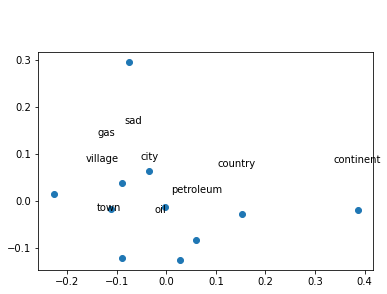

In [33]:
# We have done the plotting for you. Just run this cell.
result = compute_pca(X, 2)
plt.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0] - 0.05, result[i, 1] + 0.1))

plt.show()

**What do you notice?**

The word vectors for gas, oil and petroleum appear related to each other,
because their vectors are close to each other.  Similarly, sad, joyful
and happy all express emotions, and are also near each other.